# SBML Simulation Strategies
*Matthias König*

Reseting Models & repeated model simulations
Implementation of simulation scenarios occuring while working with computational models. These include reseting of part of the models and repeated model simulations.

**Simulation strategies**
1. Repeated simulations with varying initial conditions
2. Repeated simulations with varying parameters (& constant initial conditions)
3. Stepwise simulations (simulation for period of time, change of parameters and/or concentrations and continuation in simulation from given end model state of model)
4. Fixing variable concentrations (changing boundaryCondition=True)
5. Driving concentration or parameter with time-dependent function

In the following example code is provided on how to implement these simulation strategies.

In [50]:
from __future__ import print_function, division
%matplotlib inline

# TODO: make changes to complete Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
matplotlib.rcParams['axes.labelsize'] = 'medium'
font = {'family' : 'sans-serif',
        'weight' : 'normal', # bold
        'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pylab as plt

## Model overview
The example model consists of simple import of a substance.
`e__gal` is imported to `c__gal` via `pm_GLUT2_GAL`.

In [51]:
test_sbml = "../models/test/test_6.xml"

import antimony
antimony.loadSBMLFile(test_sbml)

mod_names = antimony.getModuleNames()
print(mod_names)
ant_string = antimony.getAntimonyString(mod_names[1])
print(ant_string)

('__main', 'test_6')
// Created by libAntimony v2.8.1
model *test_6()

  // Compartments and Species:
  compartment ext_, cyto, pm;
  species c__gal in cyto, $e__gal in ext_;

  // Assignment Rules:
  cyto := Vol_c;

  // Reactions:
  e__GLUT2_GAL in pm: $e__gal -> c__gal; (GLUT2_Vmax/GLUT2_k_gal*(e__gal - c__gal/GLUT2_keq))/(1 dimensionless + c__gal/GLUT2_k_gal + e__gal/GLUT2_k_gal);

  // Species initializations:
  c__gal = 0.00012;
  c__gal has mM;
  e__gal = 3;
  e__gal has mM;

  // Compartment initializations:
  ext_ = Vol_e;
  ext_ has m3;
  cyto has m3;
  pm = A_m;
  pm has m2;

  // Variable initializations:
  Vol_e = 1e-12;
  Vol_e has m3;
  Vol_c = x_cell*x_cell*x_cell;
  Vol_c has m3;
  A_m = 1;
  A_m has m2;
  x_cell = 2.5e-05;
  x_cell has m;
  GLUT2_Vmax = 1e-13;
  GLUT2_Vmax has mole_per_s;
  GLUT2_k_gal = 1;
  GLUT2_k_gal has mM;
  GLUT2_keq = 1;
  GLUT2_keq has dimensionless;

  // Other declarations:
  var cyto;
  const ext_, Vol_e, Vol_c, pm, A_m, x_cell, GLUT2_Vmax

## Reference simulation
We now perform a reference solution from the provided initial concentrations of the model.

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 14 2016, 11:06:00
--------------------------------------------------------------------------------
<roadrunner.RoadRunner() { 
'this' : 0x2235280
'modelLoaded' : true
'modelName' : test_6
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x282a250, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 10
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false

}>
---------------------------------

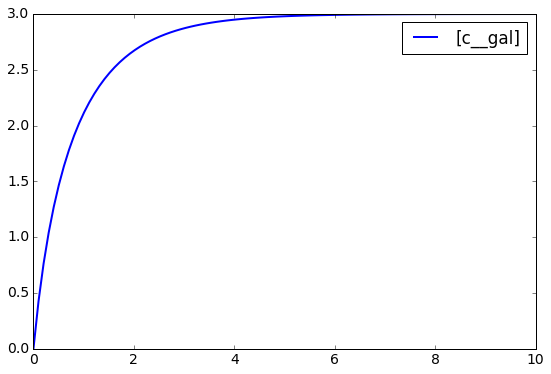

 [[        0,  0.00012],
  [  0.10101, 0.426328],
  [  0.20202, 0.763822],
  [  0.30303,  1.03995],
  [  0.40404,  1.27085],
  [ 0.505051,  1.46694],
  [ 0.606061,  1.63542],
  [ 0.707071,  1.78149],
  [ 0.808081,  1.90905]]



In [52]:
# Simulating simple test model
import roadrunner
reload(roadrunner)  # make sure latest compiled version
print(roadrunner.__version__)

r = roadrunner.RoadRunner(test_sbml)

# settings
absTol = 1E-6
relTol = 1E-6
absTol = absTol * min(r.model.getCompartmentVolumes())  # absTol relative to the amounts
integrator = r.getIntegrator()
integrator.setValue('stiff', True)
integrator.setValue('absolute_tolerance', absTol)
integrator.setValue('relative_tolerance', relTol)

# integrate
s = r.simulate(0,10, 100)
print('-'*80)
print(r)
print('-'*80)

# plot
r.plot()
# print first 10 timepoints of result
print(s[0:9, :])

## Changing values in the model
The following demonstrates how to change parameters, concentrations and amounts in the model. In addition depending variables are recalculated.

In the example model the Volume of the internal compartment `Vol_c` is calculated via an `InitialAssignment` from the cell diameter `x_cell`.

In [53]:
import numpy as np
from pandas import DataFrame
from roadrunner import SelectionRecord

# load model
r = roadrunner.RoadRunner(test_sbml)
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)

print(SelectionRecord.ALL)
print(SelectionRecord(SelectionRecord.ALL))
r.getSelectedValues()

def test_vec(r):
    return DataFrame({'x_cell': [r.x_cell, ], 
                      'Vol_c': [r.Vol_c, ], 
                      '[c__gal]': [r['[c__gal]'], ]})

# make a concentration backup (needed later)
concentration_backup = dict()
for sid in r.model.getFloatingSpeciesIds():
    concentration_backup[sid] = r["[{}]".format(sid)]

# initial state
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

-1
UNKNOWN
          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025


In [54]:
# change parameter 
# -> the depending inital assignments are not updated (makes sense, are only initial)
r.x_cell = 10E-6  # [m]
print(test_vec(r))
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1.5625e-14, 0.00012]))

# reload results in a full reset corresponding to resets(SelectionRecord.ALL)
r = roadrunner.RoadRunner(test_sbml)
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

# so do the change again
r.x_cell = 10E-6  # [m]
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1.5625e-14, 0.00012]))

          Vol_c  [c__gal]   x_cell
0  1.562500e-14   0.00012  0.00001
          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025
          Vol_c  [c__gal]   x_cell
0  1.562500e-14   0.00012  0.00001


In [55]:
# force an update via recalculating depending assignments
# -> Volume is updated, but also the concentrations due to changes in volume !
from roadrunner import SelectionRecord
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001


In [56]:
# a reset of the initial concentrations does not bring the concentrations back
r.reset()  # only reset initial concentrations
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

r.reset(SelectionRecord.INITIAL_FLOATING_CONCENTRATION)  # only reset initial concentrations
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.001875]))

# the backup of the concentrations is needed
# restore concentrations
# -> now same initial concentrations under changed parameters
for key, value in concentration_backup.iteritems():
    r.model['[{}]'.format(key)] = value
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [1.0e-05, 1e-15, 0.00012]))

          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001
          Vol_c  [c__gal]   x_cell
0  1.000000e-15  0.001875  0.00001
          Vol_c  [c__gal]   x_cell
0  1.000000e-15   0.00012  0.00001


In [57]:
# To reset all use
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)
print(test_vec(r)) 
assert(np.allclose([r.x_cell, r.Vol_c, r['[c__gal]']], 
                   [2.5e-05, 1.5625e-14, 0.00012]))

          Vol_c  [c__gal]    x_cell
0  1.562500e-14   0.00012  0.000025


## 1. Repeated simulation under changed initial conditions
Repeat the simulation with changing initial conditions

1.4.2; Compiler: gcc 4.8.4, C++ version: 199711; JIT Compiler: LLVM-3.4; Date: Jan 14 2016, 11:06:00
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

['time', '[c__gal]', '[e__gal]']


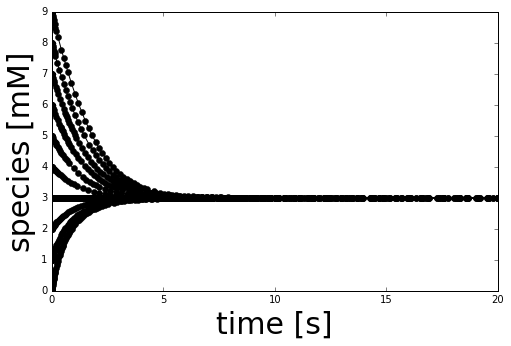

In [60]:
# load & reset model
%matplotlib inline
import roadrunner
from roadrunner import SelectionRecord
print(roadrunner.getVersionStr())

r = roadrunner.RoadRunner(test_sbml)
r.reset(SelectionRecord.ALL)  # full reset, also happening in reload, but just to be sure

# simulation settings
absTol = 1E-6
relTol = 1E-6
# absTol relative to the amounts [fix for roadrunner issue #247]
absTol = absTol * min(r.model.getCompartmentVolumes())  
integrator = r.getIntegrator()

integrator.setSetting('stiff', True)
integrator.setSetting('absolute_tolerance', absTol)
integrator.setSetting('relative_tolerance', relTol)
integrator.setSetting('variable_step_size', True)
print(integrator)

# selection
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
        
# simulation
tend = 20.0  # [s]
Nsim = 10    # number of repeats
results = []
for k in xrange(Nsim):
    # change initial concentration
    r['init([c__gal])'] = k
    # simulate
    s = r.simulate(0, tend)
    # store solution
    results.append(s)
    # reset the initial concentrations
    r.reset()

# plot the results
def plot_results(results):
    import matplotlib.pylab as plt
    plt_fontsize = 30
    plt.figure(figsize=(8,5))
    for s in results:
        plt.plot(s[:,0], s[:,1:], 'o-', color='black')
        # print('tend:', s[-1,0]) 
    
    plt.xlabel('time [s]', fontsize=plt_fontsize)
    plt.ylabel('species [mM]', fontsize=plt_fontsize)

plot_results(results)

## 2. Repeated simulation under changed parameters & fixed initial conditions
Now the more complex case of changing parameters & fixed initial conditions. 

In [61]:
# reset the model, the integration and simulate settings should still exist
print('-'*80)
print(r)
print('-'*80)

--------------------------------------------------------------------------------
<roadrunner.RoadRunner() { 
'this' : 0x26bdb90
'modelLoaded' : true
'modelName' : test_6
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x39e1e50, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 20
}>, 
'integrator' : 
< roadrunner.Integrator() >
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 1.5624999999999998e-20
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true

}>
--------------------------------------------------------------------------------


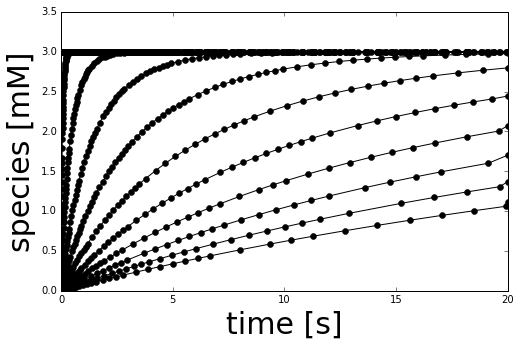

In [62]:
# make a concentration backup (needed later)
# [fix for roadrunner issue #250]
r.reset(SelectionRecord.ALL)
concentration_backup = dict()
for sid in r.model.getFloatingSpeciesIds():
    concentration_backup[sid] = r["[{}]".format(sid)]

# simulation
results = []
for k in xrange(Nsim):
    # change parameter
    r.x_cell = 10E-6 * (k+1) # [m]
    # update depending initial conditions (this should be rules!)
    r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
    # restore initial concentrations under changed parameters
    for key, value in concentration_backup.iteritems():
        r.model['[{}]'.format(key)] = value
    # simulate
    s = r.simulate(0, tend)
    # store solution
    results.append(s)
    
# plot the results
plot_results(results)

## 3. Simulation of period of time, than change of parameter/boundary condition & continuation from the given concentrations
Different solutions possible. The complete simulation can be combined from partial simulations with copying the concentrations between end and start point of simulations.

Alternative option is adding events handling the change in paramter triggered by time into the SBML model. This changes the original model.

**Challenges**
* setting a non-boundary condition to a fixed value in the simulation. This requires changes in the underlying SBML model, namely fixing as a boundarySpecies and setting the value.
* setting a certain time course function for a given species. 

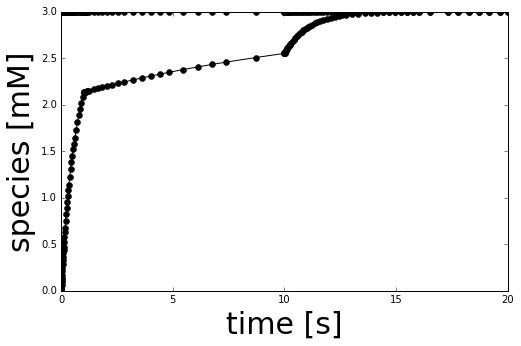

In [65]:
# Parameter/Concentration change for a certain amount of time.
def store_concentrations(r):
    """ Store FloatingSpecies concentrations of current model state. """
    c = dict()
    for sid in r.model.getFloatingSpeciesIds():
        c[sid] = r["[{}]".format(sid)]
    return c

def restore_concentrations(r, cdict):
    """ Restore the FloatingSpecies concentrations given in the dict. """
    for key, value in cdict.iteritems():
        r.model['[{}]'.format(key)] = value

# reset model
r.reset(SelectionRecord.ALL)

# storage for partial results
results = []
tends = [1, 10, 20]

# *** s1 ***
# simulate & store concentrations at end point
s1 = r.simulate(0, tends[0])
c1 = store_concentrations(r)
results.append(s1)

# *** s2 ***
# change parameters
x_cell = r.x_cell  # store old value
r.x_cell = 60E-6   # set new value
# update depending initial conditions (this should be rules!)
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
# set concentrations & simulate
restore_concentrations(r, c1)
s2 = r.simulate(tends[0], tends[1])
c2 = store_concentrations(r)
results.append(s2)

# *** s3 ***
r.x_cell = x_cell  # restore value
# update depending initial conditions
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
# set concentrations
restore_concentrations(r, c2)
s3 = r.simulate(tends[1], tends[2])
results.append(s3)
# print(results)

# concatenate results
import numpy as np
s = np.concatenate(results, axis=0)

# plot the results
plot_results([s])
# plot_results(results)
# print(results)   # [issue #257]

### boundaryConditions
Species values can easily be set to fixed values via the boundaryCondition flag.
In case of non-boundary conditions the boundaryConditions have to be set true first.

<Species c__gal "D-galactose">
<Species e__gal "D-galactose">
--------------------------------------------------------------------------------
*** Normal boundary conditions ***
['time', '[c__gal]', '[e__gal]']
--------------------------------------------------------------------------------
*** Altered boundary conditions ***
['time', '[e__gal]', '[c__gal]']


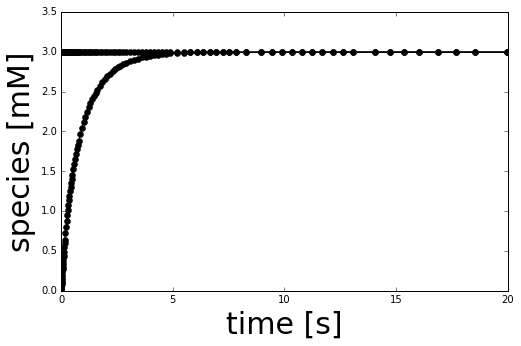

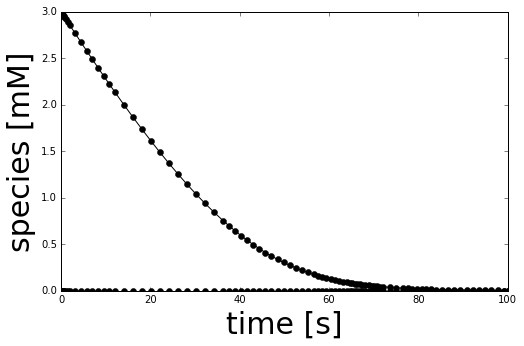

In [70]:
# ---------------------------------------
# SBML model modifications
# ---------------------------------------

import libsbml
# get model
doc = libsbml.readSBML(test_sbml)
model = doc.getModel()
model_id = model.getId()
# update model id
model_id_bc = '{}_boundaryCondition'.format(model_id)
model.setId(model_id_bc)

# get species
s_cgal = model.getSpecies("c__gal")
print(s_cgal)
s_egal = model.getSpecies("e__gal")
print(s_egal)

# Change the boundary conditions (True <-> False)
s_cgal.setBoundaryCondition(True)
s_egal.setBoundaryCondition(False)

bc_sbml = '../models/test/{}.xml'.format(model_id_bc)
libsbml.writeSBMLToFile(doc, bc_sbml)


def set_settings(r):
    ''' 
    Sets all integrator settings in roadrunner.
    Necessary after every reload of models.
    '''
    # simulation settings
    absTol = 1E-6
    relTol = 1E-6
    # absTol relative to the amounts [fix for roadrunner issue #247]
    absTol = absTol * min(r.model.getCompartmentVolumes())  
    integrator = r.getIntegrator()
    integrator.setSetting('stiff', True)
    integrator.setSetting('absolute_tolerance', absTol)
    integrator.setSetting('relative_tolerance', relTol)
    integrator.setSetting('variable_step_size', True)
    

# ---------------------------------------
# Model simulations
# ---------------------------------------
import roadrunner
from roadrunner import SelectionRecord

print('-'*80)
print('*** Normal boundary conditions ***')
r = roadrunner.RoadRunner(test_sbml)
set_settings(r)
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
# print(r)
s1 = r.simulate(0,20)
plot_results([s1])

print('-'*80)
print('*** Altered boundary conditions ***')
r = roadrunner.RoadRunner(bc_sbml)
set_settings(r)
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
print(r.selections)
# print(r)
s2 = r.simulate(0,100)
plot_results([s2])

### time varying species & parameters
The most complex simulation scenario is driving the model via time dependent functions, either for parameters  or species concentrations.


 filename: ../models/test/test_6_time.xml
 file size: 12949
 read time (ms): 0.00682
 validation error(s): 0

--------------------------------------------------------------------------------
*** Time dependent boundary conditions ***
--------------------------------------------------------------------------------


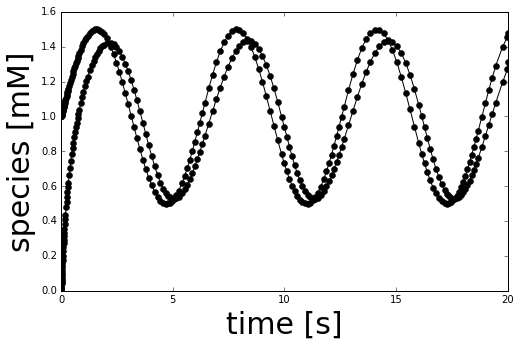

In [71]:
# ---------------------------------------
# SBML model modifications
# ---------------------------------------
# add a time dependent species concentration
# This is only possible on species with boundaryCondition=True (see above for setting).
# The change in the variable is set via an assignment rule

import libsbml
import multiscale.sbmlutils.factory as factory
import  multiscale.sbmlutils.sbmlio as sbmlio
reload(factory)
reload(sbmlio)

# get model
doc = libsbml.readSBML(test_sbml)
model = doc.getModel()
model_id = model.getId()
model_id_time = '{}_time'.format(model.getId())
model.setId(model_id_time)

# The boundaryCondition species is driven via the following rule
factory.create_assignment_rules(model, 
                          rules=[{'id': 'e__gal', 
                                  'value': '1.0 mM + 0.5 mM * sin(time/1 s)', 
                                  'unit': 'mM'}, ])
time_sbml = '../models/test/{}.xml'.format(model_id_time)
sbmlio.write_and_check(doc, time_sbml)

# ---------------------------------------
# Model simulations
# ---------------------------------------
import roadrunner    

print('-'*80)
print('*** Time dependent boundary conditions ***')
r = roadrunner.RoadRunner(time_sbml)
print('-'*80)
set_settings(r)
r.selections = ['time'] + \
        ['[{}]'.format(sid) for sid in r.model.getFloatingSpeciesIds()] + \
        ['[{}]'.format(sid) for sid in r.model.getBoundarySpeciesIds()]
s1 = r.simulate(0,20)
plot_results([s1])